In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import pandas as pd
from pathlib import Path
from tqdm.autonotebook import tqdm
import pandas_profiling as pd_pro
import cufflinks as cf; cf.go_offline()
from googletrans import Translator
from copy import deepcopy as copy
import datetime

https://www.kaggle.com/c/competitive-data-science-predict-future-sales

2013/1 ~ 2015/10までの学習データを使って2015/11の店毎/アイテム毎の月の販売数を予測する

# Read data

In [3]:
filelist = list(Path("data").glob("*.csv"))
filelist

[PosixPath('data/shops.csv'),
 PosixPath('data/item_categories.csv'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/items.csv'),
 PosixPath('data/test.csv'),
 PosixPath('data/sales_train.csv')]

**File descriptions**
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

**Data fields**
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

[Data](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

In [4]:
data = {
    "train": pd.read_csv("data/sales_train.csv", parse_dates=[0]),
    "test": pd.read_csv("data/test.csv"),
    "shops": pd.read_csv("data/shops.csv"),
    "items": pd.read_csv("data/items.csv"),
    "item_cat": pd.read_csv("data/item_categories.csv"),
    "sample": pd.read_csv("data/sample_submission.csv")
}

In [7]:
for key in data.keys():
    print(key)
    display(data[key].head())

train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


test


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


shops


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


items


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


item_cat


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


sample


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


## 翻訳

In [9]:
s = data["item_cat"]["item_category_name"][0]
s

'PC - Гарнитуры/Наушники'

In [13]:
translator = Translator()
result = translator.translate(s, dest="ja")

In [22]:
result.__dict__["text"]

'PC  - ヘッドセット/ヘッドフォン'

In [23]:
def translate_to_ja(s):
    translator = Translator()
    result = translator.translate(s, dest="ja")
    return result.__dict__["text"]

In [39]:
tqdm.pandas(desc="translate")
data["item_cat"]["item_category_name_ja"] = data["item_cat"]["item_category_name"].progress_apply(translate_to_ja)
data["item_cat"].head()

,item_category_name,item_category_id,item_category_name_ja
0,PC - Гарнитуры/Наушники,0,PC - ヘッドセット/ヘッドフォン
1,Аксессуары - PS2,1,アクセサリー - PS2
2,Аксессуары - PS3,2,アクセサリー - PS3
3,Аксессуары - PS4,3,アクセサリー - PS4
4,Аксессуары - PSP,4,アクセサリ - PSP


In [27]:
data["item_cat"]["item_category_name_ja"].unique()

array(['PC  - ヘッドセット/ヘッドフォン', 'アクセサリー -  PS2', 'アクセサリー -  PS3',
       'アクセサリー -  PS4', 'アクセサリ -  PSP', 'アクセサリー -  PSVITA',
       'アクセサリー -  XBOX 360', 'アクセサリー -  XBOX ONE', 'チケット（桁）', '納品',
       'ゲーム機 -  PS2', 'ゲームコンソール -  PS3', 'ゲーム機 -  PS4', 'ゲーム機 -  PSP',
       'ゲーム機 -  PSVITA', 'ゲーム機 -  XBOX 360', 'ゲーム機 -  XBOX ONE',
       'ゲーム機 - その他', 'ゲーム -  PS2', 'ゲーム -  PS3', 'ゲーム -  PS4',
       'ゲーム -  PSP', 'ゲーム -  PSVITA', 'ゲーム -  XBOX 360',
       'ゲーム -  XBOX ONE', 'ゲーム - ゲームのためのアクセサリー', 'ゲームアンドロイド - デジタル',
       'ゲームMAC  - デジタル', 'ゲームPC  - 追加の出版物', 'ゲームPC  - コレクターズ・エディション',
       'ゲームPC  - スタンダード版', 'ゲームPC  - デジタル', '支払カード（ビデオ、音楽、ゲーム）',
       '支払カード - ライブ！', '支払カード - ライブ！ （デジタル）', '支払カード -  PSN',
       '支払カード -  Windowsの（フィギュア）', '作品 - ブルーレイ', '作品 - ブルーレイ3D',
       'ムービー - ブルーレイ4K', 'ムービー -  DVD', 'シネマ - コレクタ', '書籍 - アートブック、百科事典',
       '書籍 - オーディオブック', '書籍 - オーディオブック（フィギュア）', '書籍 - オーディオブック1C',
       '書籍 - ビジネスブックス', '書籍 - コミック、マンガ', '書籍 - コンピュータブックス',
       '書籍 - 系統的材料1C

# 初期データでの性能チェック

## データ準備

In [5]:
train = copy(data["train"])
train = train.set_index("date")
# train["year"] = train["date"].apply(lambda x: x.year)
# train["month"] = train["date"].apply(lambda x: x.month)
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-02-01,0,59,22154,999.00,1.0
2013-03-01,0,25,2552,899.00,1.0
2013-05-01,0,25,2552,899.00,-1.0
2013-06-01,0,25,2554,1709.05,1.0
2013-01-15,0,25,2555,1099.00,1.0


In [6]:
train_gb = train.groupby([train.index.year, train.index.month, "item_id", "shop_id"])["item_cnt_day"].sum()
train_gb.index.names = ["year", "month", "item_id", "shop_id"]
train_gb = train_gb.reset_index().rename(columns={"item_cnt_day": "item_cnt_month"})
train_gb

,year,month,item_id,shop_id,item_cnt_month
0,2013,1,27,5,1.0
1,2013,1,27,10,1.0
2,2013,1,27,31,1.0
3,2013,1,28,15,1.0
4,2013,1,28,19,2.0
...,...,...,...,...,...
1799390,2015,12,22167,25,1.0
1799391,2015,12,22167,27,1.0
1799392,2015,12,22167,31,1.0
1799393,2015,12,22167,42,1.0


In [22]:
test = copy(data["test"])
test.insert(loc=1, column="month", value=11)
test.insert(loc=1, column="year", value=2015)
test = test.drop("ID", axis=1)
test

,year,month,shop_id,item_id
0,2015,11,5,5037
1,2015,11,5,5320
2,2015,11,5,5233
3,2015,11,5,5232
4,2015,11,5,5268
...,...,...,...,...
214195,2015,11,45,18454
214196,2015,11,45,16188
214197,2015,11,45,15757
214198,2015,11,45,19648


## モデル学習

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [10]:
target_col = "item_cnt_month"
learn_col = list(train_gb.columns)
learn_col.remove(target_col)
print(target_col, "←", learn_col)

item_cnt_month ← ['year', 'month', 'item_id', 'shop_id']


In [18]:
train_x, train_y = train_gb[learn_col], train_gb[target_col]
mms = MinMaxScaler()
train_x = pd.DataFrame(mms.fit_transform(train_x), columns=train_x.columns)
train_x.head()

,year,month,item_id,shop_id
0,0.0,0.0,0.001218,0.084746
1,0.0,0.0,0.001218,0.169492
2,0.0,0.0,0.001218,0.525424
3,0.0,0.0,0.001263,0.254237
4,0.0,0.0,0.001263,0.322034


In [20]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
test2 = mms.transform(test)
predict = pd.Series(lr.predict(test2))
test["item_cnt_month"] = predict
# test = pd.DataFrame(mms.inverse_transform(test), columns=test.columns)
test

,year,month,shop_id,item_id,item_cnt_month
0,2015,11,5,5037,5.729836
1,2015,11,5,5320,5.928951
2,2015,11,5,5233,5.867739
3,2015,11,5,5232,5.867035
4,2015,11,5,5268,5.892364
...,...,...,...,...,...
214195,2015,11,45,18454,15.169438
214196,2015,11,45,16188,13.575108
214197,2015,11,45,15757,13.271862
214198,2015,11,45,19648,16.009522


In [46]:
submission = copy(test["item_cnt_month"])
submission = submission.reset_index()
submission.rename(columns={"index": "ID"}, inplace=True)
now = lambda :datetime.datetime.now().strftime("%Y%m%d%H%M%S")
submission.to_csv(f"results/{now()}.csv", index=False)

# Profile
## train

In [ ]:
profile = pd_pro.ProfileReport(data["train"])
profile.to_file("profile/train_profile.html")

[train_profile](profile/train_profile.html)

### 外れ値除去
#### item_price

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

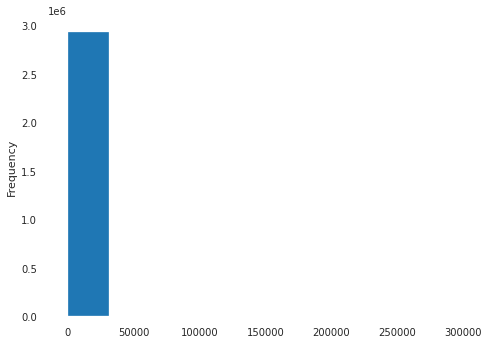

In [50]:
train = data["train"]
train["item_price"].plot(kind="hist")
train["item_price"].describe()

count    2.788632e+06
mean     6.408760e+02
std      5.958757e+02
min     -1.000000e+00
25%      2.480000e+02
50%      3.990000e+02
75%      8.490000e+02
max      2.689900e+03
Name: item_price, dtype: float64

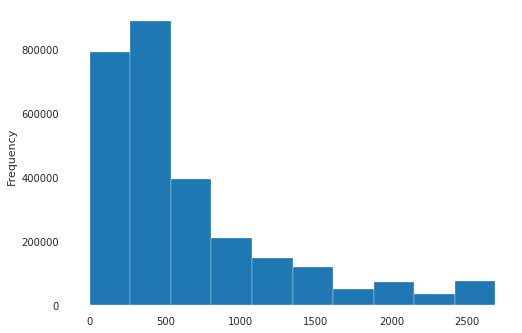

In [51]:
quant = train["item_price"].quantile(0.95)
data["train"] = train[train["item_price"] < quant]
data["train"]["item_price"].plot(kind="hist")
data["train"]["item_price"].describe()

#### item_cnt_day

count    2.788632e+06
mean     1.233619e+00
std      2.611853e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

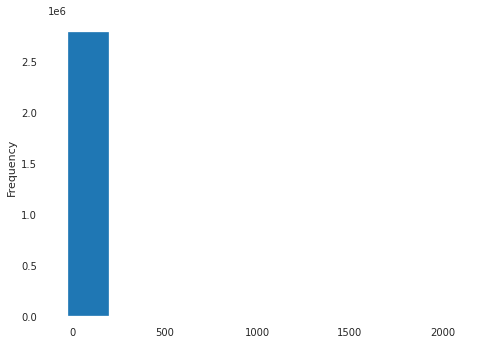

In [52]:
data["train"]["item_cnt_day"].plot(kind="hist")
data["train"]["item_cnt_day"].describe()

In [53]:
data["train"]["item_cnt_day"].nlargest(10)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
2626181     539.0
2851073     533.0
2048518     512.0
2067669     508.0
2864260     504.0
Name: item_cnt_day, dtype: float64

In [56]:
data["train"] = data["train"][data["train"]["item_cnt_day"] < 500]

#### date

In [58]:
data["train"]["date"]

0         2013-02-01
1         2013-03-01
2         2013-05-01
3         2013-06-01
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-09-10
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-03-10
Name: date, Length: 2788618, dtype: datetime64[ns]

## items

In [ ]:
profile2 = pd_pro.ProfileReport(data["items"])
profile2.to_file("profile/item_profile.html")

[items_profile](profile/item_profile.html)